In [55]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os
import warnings

warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/content/sickness_table.csv')

In [24]:
#Step 1: Data Cleaning and Preprocessing
# Remove unnecessary columns
sickness_data_cleaned = data.drop(columns=['Unnamed: 0']) # Changed sickness_data to data

# Convert 'date' to datetime for easier time-based analysis
sickness_data_cleaned['date'] = pd.to_datetime(sickness_data_cleaned['date'])

In [25]:
# Data Quality Check
def data_quality_summary(df):
    print("Data Summary:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())

In [26]:
# Perform data quality check
data_quality_summary(sickness_data_cleaned)

Data Summary:
                      date       n_sick         calls       n_duty   n_sby  \
count                 1152  1152.000000   1152.000000  1152.000000  1152.0   
mean   2017-10-28 12:00:00    68.808160   7919.531250  1820.572917    90.0   
min    2016-04-01 00:00:00    36.000000   4074.000000  1700.000000    90.0   
25%    2017-01-13 18:00:00    58.000000   6978.000000  1800.000000    90.0   
50%    2017-10-28 12:00:00    68.000000   7932.000000  1800.000000    90.0   
75%    2018-08-12 06:00:00    78.000000   8827.500000  1900.000000    90.0   
max    2019-05-27 00:00:00   119.000000  11850.000000  1900.000000    90.0   
std                    NaN    14.293942   1290.063571    80.086953     0.0   

          sby_need       dafted  
count  1152.000000  1152.000000  
mean     34.718750    16.335938  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%      12.250000     0.000000  
max     555.000000   465.000000  
std      79

(array([16922., 17045., 17167., 17287., 17410., 17532., 17652., 17775.,
        17897., 18017.]),
 [Text(16922.0, 0, '2016-05'),
  Text(17045.0, 0, '2016-09'),
  Text(17167.0, 0, '2017-01'),
  Text(17287.0, 0, '2017-05'),
  Text(17410.0, 0, '2017-09'),
  Text(17532.0, 0, '2018-01'),
  Text(17652.0, 0, '2018-05'),
  Text(17775.0, 0, '2018-09'),
  Text(17897.0, 0, '2019-01'),
  Text(18017.0, 0, '2019-05')])

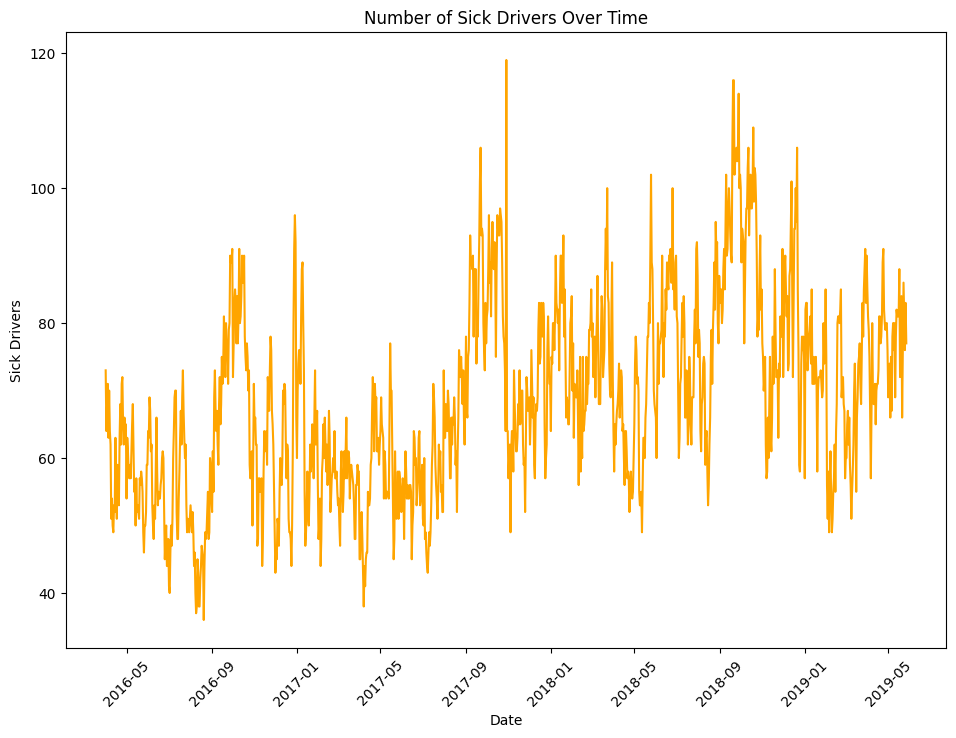

In [32]:
# Visualize trends of sick drivers and emergency calls over time
plt.figure(figsize=(25, 8))

# Number of sick drivers
plt.subplot(1, 2, 1)
plt.plot(sickness_data_cleaned['date'], sickness_data_cleaned['n_sick'], color='orange')
plt.title('Number of Sick Drivers Over Time')
plt.xlabel('Date')
plt.ylabel('Sick Drivers')
plt.xticks(rotation=45)

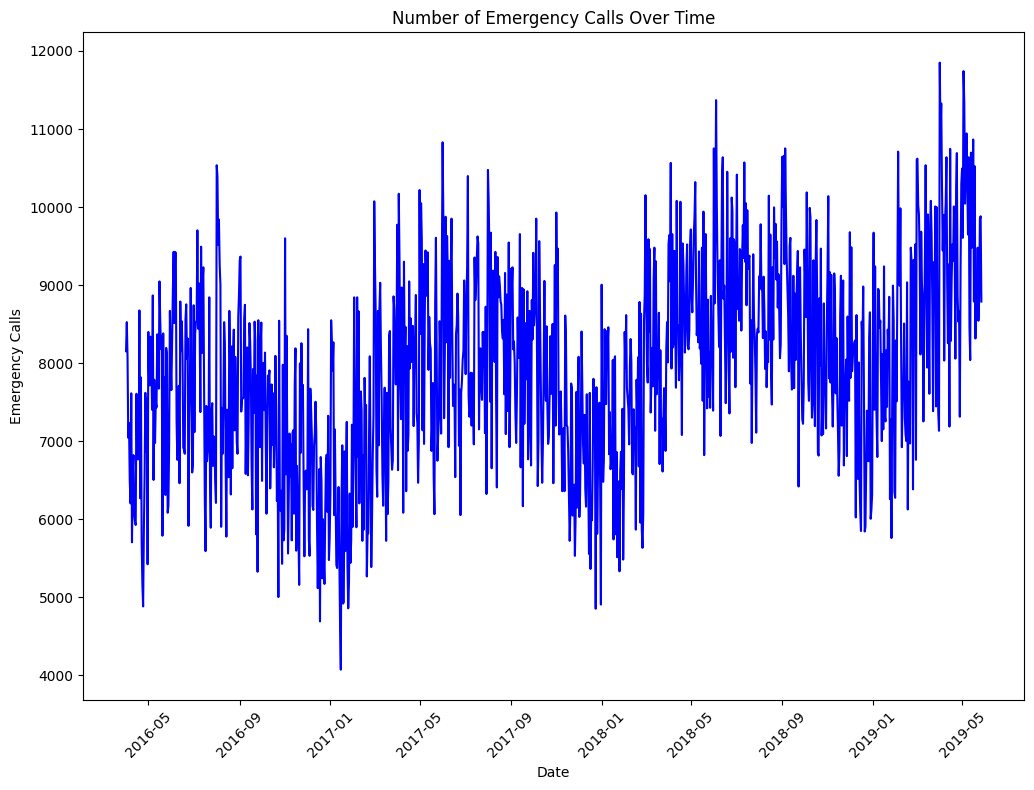

In [30]:
# Number of emergency calls
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 2)
plt.plot(sickness_data_cleaned['date'], sickness_data_cleaned['calls'], color='blue')
plt.title('Number of Emergency Calls Over Time')
plt.xlabel('Date')
plt.ylabel('Emergency Calls')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

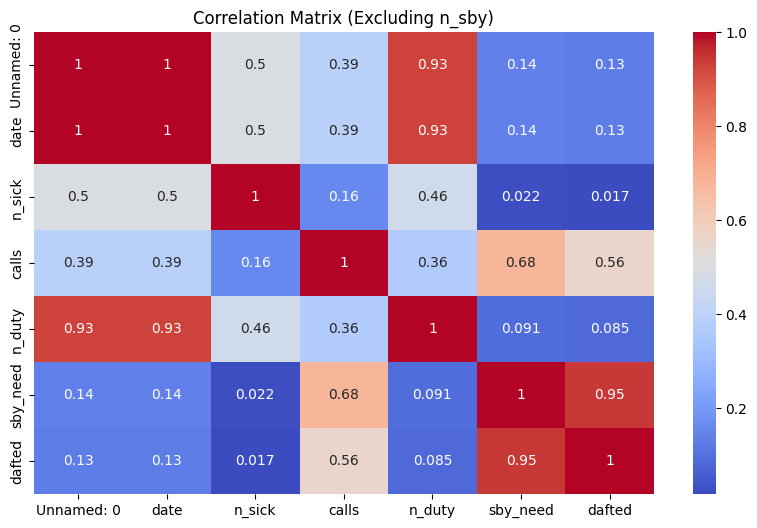

In [38]:
# Correlation analysis excluding n_sby
plt.figure(figsize=(10, 6))
sns.heatmap(data.drop(columns=['n_sby']).corr(), annot=True, cmap="coolwarm")
plt.title('Correlation Matrix (Excluding n_sby)')
plt.show()


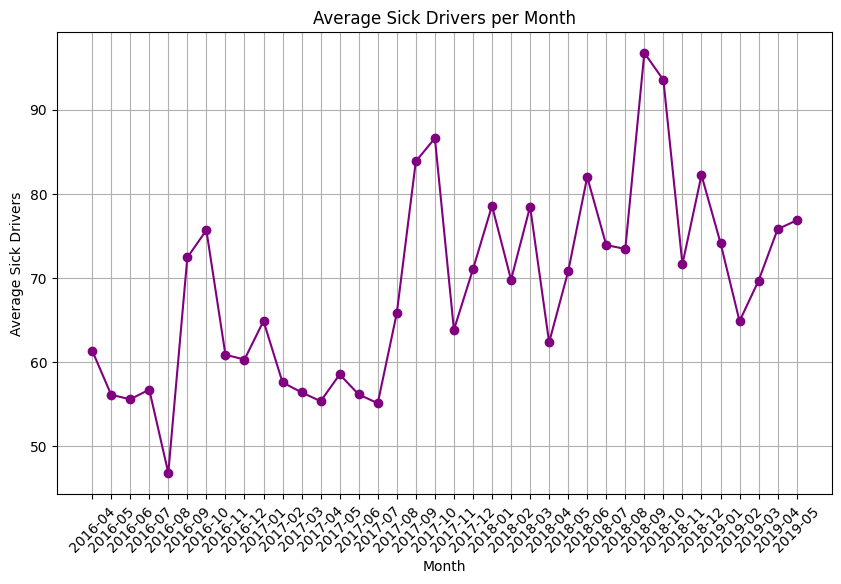

In [40]:
# Sickness trend with month-wise aggregation (to check for seasonal patterns)
sickness_data_cleaned['month'] = sickness_data_cleaned['date'].dt.to_period('M')

monthly_sickness = sickness_data_cleaned.groupby('month')['n_sick'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(monthly_sickness['month'].astype(str), monthly_sickness['n_sick'], marker='o', color='purple')
plt.title('Average Sick Drivers per Month')
plt.xlabel('Month')
plt.ylabel('Average Sick Drivers')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

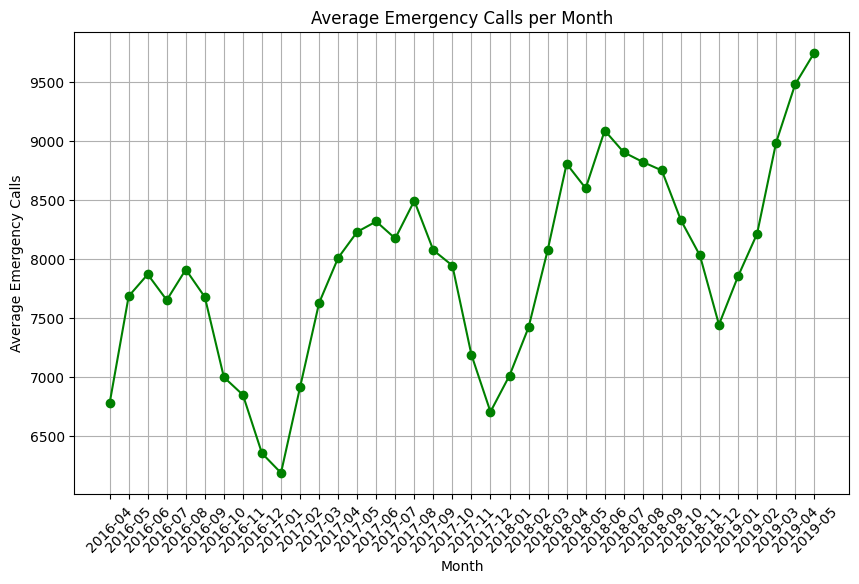

In [41]:
# Emergency calls trend with month-wise aggregation
monthly_calls = sickness_data_cleaned.groupby('month')['calls'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(monthly_calls['month'].astype(str), monthly_calls['calls'], marker='o', color='green')
plt.title('Average Emergency Calls per Month')
plt.xlabel('Month')
plt.ylabel('Average Emergency Calls')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [42]:
# Baseline model (naive approach): Using average of past data to predict standby needs
avg_sick_drivers = sickness_data_cleaned['n_sick'].mean()
avg_calls = sickness_data_cleaned['calls'].mean()

print(f"Baseline Estimate for Standby Drivers: {avg_sick_drivers:.2f}")
print(f"Baseline Estimate for Emergency Calls: {avg_calls:.2f}")

Baseline Estimate for Standby Drivers: 68.81
Baseline Estimate for Emergency Calls: 7919.53


In [43]:
# Predictive Model: Random Forest
# Define features and target (predict standby needs 'sby_need')
X = sickness_data_cleaned[['n_sick', 'calls', 'n_duty', 'n_sby']]
y = sickness_data_cleaned['sby_need']

In [44]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [46]:
# Predict on test data
y_pred = rf_model.predict(X_test)

In [47]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [48]:
print(f"Random Forest Model - Mean Absolute Error: {mae:.2f}")
print(f"Random Forest Model - R2 Score: {r2:.2f}")

Random Forest Model - Mean Absolute Error: 1.86
Random Forest Model - R2 Score: 0.99


In [57]:
!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 16.0 MB/s eta 0:00:00


In [58]:
# Model Interpretability using SHAP
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

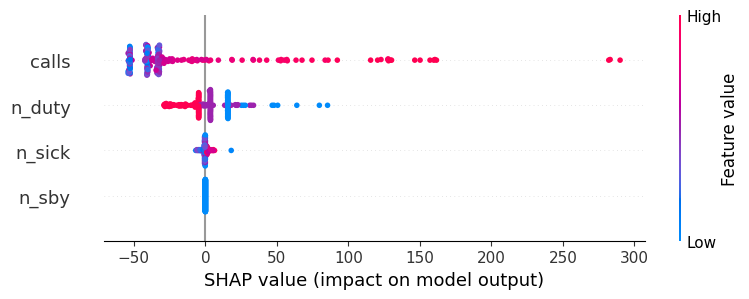

In [59]:
# Plot feature importance
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

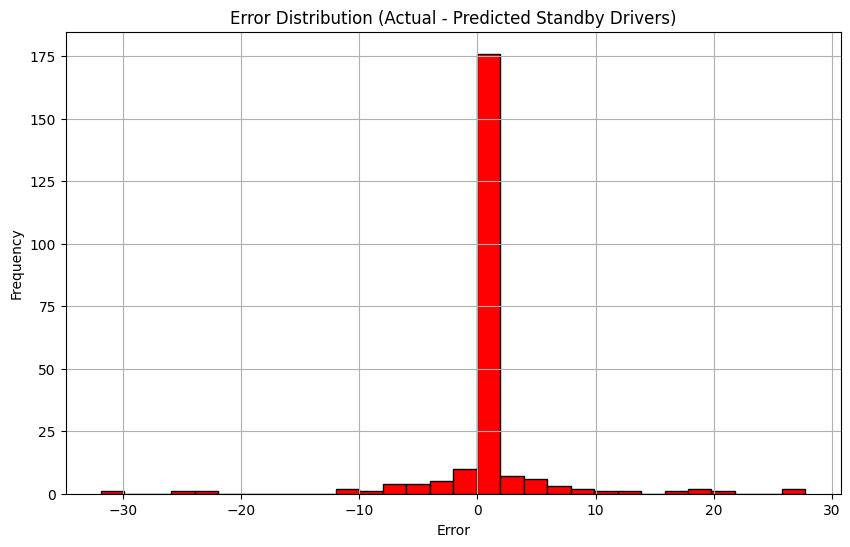

In [60]:
# Error analysis
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, color='red', edgecolor='black')
plt.title('Error Distribution (Actual - Predicted Standby Drivers)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Model Accuracy Metrics:
Mean Absolute Error (MAE): 1.86
Root Mean Squared Error (RMSE): 5.30
R² (R-squared): 0.99


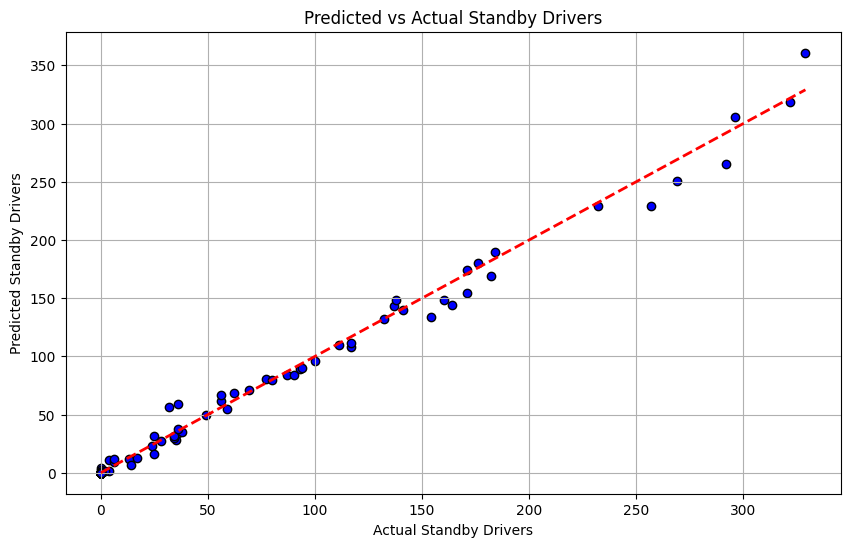

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluate the model on test data
y_pred = rf_model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Display accuracy results
print(f"Model Accuracy Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² (R-squared): {r2:.2f}")

# Optional: Visualize predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolor='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicted vs Actual Standby Drivers')
plt.xlabel('Actual Standby Drivers')
plt.ylabel('Predicted Standby Drivers')
plt.grid(True)
plt.show()
